In [6]:
import keras
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import SGD
import tensorflow as tf
import glob
import os
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import *
from random import shuffle

In [7]:
feature_size = 128
sequence_size = 10

selected_classes = list(sorted([137, 0, 300, 138, 139, 27, 307, 72, 510, 239, 5]))
NUM_CLASSES = len(selected_classes) #527

# Data input

In [8]:
DATA_DIR = '/home/timo/Documents/MD/Data/AudioSet/audioset_v1_embeddings'
train_folder = os.path.join(DATA_DIR, 'bal_train')
train_files = glob.glob(os.path.join(train_folder, '*'))
validation_folder = os.path.join(DATA_DIR, 'eval')
validation_files = glob.glob(os.path.join(validation_folder, '*'))

In [9]:
def generate_from_records(tfrecords_filename):
    record_iterator = tf.python_io.tf_record_iterator(path=tfrecords_filename)

    for string_record in record_iterator:
        example = tf.train.SequenceExample()
        example.ParseFromString(string_record)

        label = example.context.feature['labels'].int64_list.value
        video_id = example.context.feature['video_id'].bytes_list.value
        
        features = example.feature_lists.feature_list['audio_embedding'].feature
        features_np = np.asarray([np.frombuffer(f.bytes_list.value[0], dtype=np.uint8).astype(np.float32) for f in features])
        yield label, video_id, features_np

In [64]:
def generate_from_records_features_only(tfrecords_filename):
    record_iterator = tf.python_io.tf_record_iterator(path=tfrecords_filename)

    for string_record in record_iterator:
        example = tf.train.SequenceExample()
        example.ParseFromString(string_record)

        features = example.feature_lists.feature_list['audio_embedding'].feature
        features_np = np.asarray([np.frombuffer(f.bytes_list.value[0], dtype=np.uint8).astype(np.float32) for f in features])
        print("Length: ", len(features_np))
        for i in range(0, len(features_np)-10):
            yield features_np[i:i+10]

In [65]:
def generate_from_folder(folder_name):
    print('generate_from_folder')
    filenames = sorted(glob.glob(os.path.join(folder_name, '*')))
    while True:
        shuffle(filenames)
        for fname in filenames:
            yield from generate_from_records(fname)
    
def generate_from_folder_features_only(folder_name):
    print('generate_from_folder')
    filenames = sorted(glob.glob(os.path.join(folder_name, '*')))
    while True:
        for fname in filenames:
            yield from generate_from_records_features_only(fname)
    
#     filename_queue = tf.train.string_input_producer(filenames)
#     res = filename_queue.dequeue()
#     with sess.as_default():
#         sess.run(tf.local_variables_initializer())
#         coord = tf.train.Coordinator()
#         threads = tf.train.start_queue_runners(coord=coord)
#         while not coord.should_stop():
#             yield from generate_from_records(sess.run(res))

In [52]:
def pad_sequence(features, target_size):
    return np.pad(features, ((0, target_size - features.shape[0]), (0, 0)), 'constant', constant_values=0)

In [53]:
binarizer = MultiLabelBinarizer(classes=np.arange(NUM_CLASSES))
def keras_generator_flat(folder, batch_size=10, normalize=True):
    generator = generate_from_folder(folder)
    while True:
        batch_features = []
        batch_labels = []
        while len(batch_features) != batch_size:
            labels, _, features = next(generator)
            features = pad_sequence(features[:10], sequence_size).flatten()
            if selected_classes is not None:
                labels = list(set(labels) & set(selected_classes))
                labels = [selected_classes.index(c) for c in labels]
                if len(labels) == 0:
                    continue
            batch_features.append(features)
            batch_labels.append(tuple(labels))
        batch_features = np.asarray(batch_features)
        if normalize:
            batch_features /= 255.
        batch_labels = binarizer.fit_transform(batch_labels)
        yield batch_features, batch_labels

In [87]:
def keras_generator_flat_features_only(folder, batch_size=10, normalize=True):
    generator = generate_from_folder_features_only(folder)
    while True:
        batch_features = []
        batch_labels = []
        while len(batch_features) < batch_size:
            features = next(generator)
            features = pad_sequence(features[:10], sequence_size).flatten()
            batch_features.append(features)
        batch_features = np.asarray(batch_features)
        print(batch_features.shape)
        
        if normalize:
            batch_features /= 255.
        yield batch_features

# Model

In [81]:
model = Sequential()
model.add(Dense(feature_size * sequence_size, activation='relu', input_dim=(feature_size * sequence_size)))
model.add(Dropout(0.1))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(NUM_CLASSES, activation='sigmoid'))

In [82]:
model

In [83]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 1280)              1639680   
_________________________________________________________________
dropout_10 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              1311744   
_________________________________________________________________
dropout_11 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 11)                11275     
Total para

In [84]:
def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [18]:
POS_WEIGHT = 5  # multiplier for positive targets, needs to be tuned
import keras.backend.tensorflow_backend as tfb

def weighted_binary_crossentropy(target, output):
    """
    Weighted binary crossentropy between an output tensor 
    and a target tensor. POS_WEIGHT is used as a multiplier 
    for the positive targets.

    Combination of the following functions:
    * keras.losses.binary_crossentropy
    * keras.backend.tensorflow_backend.binary_crossentropy
    * tf.nn.weighted_cross_entropy_with_logits
    """
    # transform back to logits
    _epsilon = tfb._to_tensor(tfb.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    output = tf.log(output / (1 - output))
    # compute weighted loss
    loss = tf.nn.weighted_cross_entropy_with_logits(targets=target,
                                                    logits=output,
                                                    pos_weight=POS_WEIGHT)
    return tf.reduce_mean(loss, axis=-1)

In [86]:
def jaccard_sim(y_true, y_pred):
    y_pred_bin = y_pred > 0.5
    
    return jaccard_similarity_score(y_true, y_pred > 0.5)

def precision(y_true, y_pred):
    return precision_score(y_true, y_pred > 0.5, average='samples')

def recall(y_true, y_pred):
    return recall_score(y_true, y_pred > 0.5, average='samples')

In [87]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=weighted_binary_crossentropy, optimizer=sgd, metrics=['accuracy'])

In [110]:
batch_size = 10
num_epochs = 10

train_generator = keras_generator_flat(train_folder, generate_from_folder, batch_size)
validation_generator = keras_generator_flat(validation_folder, generate_from_folder, batch_size)

In [111]:
history = model.fit_generator(train_generator, steps_per_epoch=22160 // batch_size,
                              validation_data=validation_generator, validation_steps = 20371 // batch_size, verbose=1,
                              epochs=num_epochs)

generate_from_foldergenerate_from_folder
Epoch 1/10

2216/2216 [==============================] - 42s 19ms/step - loss: 0.3625 - acc: 0.7646 - val_loss: 0.3279 - val_acc: 0.7396
Epoch 2/10
2216/2216 [==============================] - 41s 19ms/step - loss: 0.2769 - acc: 0.7958 - val_loss: 0.3080 - val_acc: 0.8127
Epoch 3/10
2216/2216 [==============================] - 41s 19ms/step - loss: 0.2483 - acc: 0.8025 - val_loss: 0.2900 - val_acc: 0.7883
Epoch 4/10
2216/2216 [==============================] - 41s 19ms/step - loss: 0.2204 - acc: 0.8078 - val_loss: 0.3084 - val_acc: 0.8044
Epoch 5/10
2216/2216 [==============================] - 41s 19ms/step - loss: 0.2034 - acc: 0.8118 - val_loss: 0.3264 - val_acc: 0.7920
Epoch 6/10
2216/2216 [==============================] - 42s 19ms/step - loss: 0.1794 - acc: 0.8207 - val_loss: 0.3365 - val_acc: 0.7690
Epoch 7/10
2216/2216 [==============================] - 42s 19ms/step - loss: 0.1590 - acc: 0.8296 - val_loss: 0.4065 - val_acc: 0.7839
Epoch 

In [112]:
model.save('10_epochs_binary_crossentropy_weighted_5_11_classes.hdf5')

In [44]:
val_X = []
val_y = []
for i in range(20371 // batch_size):
    X, y_true = next(validation_generator)
    val_X.extend(X)
    val_y.extend(y_true)


In [45]:
val_X = np.asarray(val_X)
val_y = np.asarray(val_y)

In [58]:
y_pred = model.predict(val_X, batch_size)

In [17]:
import tqdm

In [59]:
p = []
r = []
j = []
ts = np.linspace(0.0, 1.0, 11)
for thres in tqdm.tqdm(ts):
    precisions = []
    recalls = []
    jaccs = []
    prec = precision_score(val_y, y_pred >= thres, average='samples')
    recall = recall_score(val_y, y_pred >= thres, average='samples')
    jacc = jaccard_similarity_score(val_y, y_pred > 0.5)
    precisions.append(prec)
    recalls.append(recall)
    jaccs.append(jacc)
    p.append(np.mean(precisions))
    r.append(np.mean(recalls))
    j.append(np.mean(jacc))

 64%|██████▎   | 7/11 [00:08<00:04,  1.17s/it]/home/timo/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
100%|██████████| 11/11 [00:12<00:00,  1.10s/it]


In [24]:
import matplotlib.pyplot as plt

In [32]:
j

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

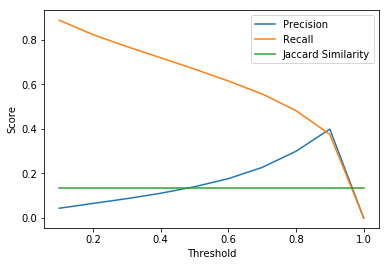

In [80]:
plt.plot(ts[1:], p[1:], label='Precision')
plt.plot(ts[1:], r[1:], label='Recall')
plt.plot(ts[1:], j[1:], label='Jaccard Similarity')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

In [48]:
print(precision_score(y, y_pred > 0.5, average='samples'))
print(recall_score(y, y_pred > 0.5, average='samples'))
print(jaccard_similarity_score(y, y_pred > 0.5))

0.121535765821
0.55
0.0935559678417


In [46]:
hamming_loss(y, y_pred > 0.5)

0.02713472485768501

In [37]:
for t in np.linspace(0.0, 1.0, 11):
    print(t)
#y_pred >= 0.5

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


# Predict on audio

In [19]:
from keras.models import load_model
model = load_model('10_epochs_binary_crossentropy_weighted_40.hdf5', custom_objects={'weighted_binary_crossentropy':weighted_binary_crossentropy})

In [93]:
import pandas as pd

In [95]:
class_labels = pd.read_csv('~/Documents/MD/Data/AudioSet/class_labels_indices.csv')

In [98]:
labels_names = class_labels['display_name'].as_matrix()

In [32]:
print(glob.glob(os.path.join(DATA_DIR, 'test', '*')))

['/home/timo/Documents/MD/Data/AudioSet/audioset_v1_embeddings/test/audio.tfrecord']


In [88]:
gen = keras_generator_flat_features_only(os.path.join(DATA_DIR, 'test'), 10)

In [89]:
next(gen)

generate_from_folder
Length:  115
(10, 1280)


array([[ 0.67058825,  0.03529412,  0.78431374, ...,  0.82352942,
         0.        ,  1.        ],
       [ 0.60000002,  0.01568628,  0.58823532, ...,  0.44313726,
         1.        ,  1.        ],
       [ 0.58039218,  0.        ,  0.63921571, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 0.69411767,  0.03529412,  0.60392159, ...,  0.        ,
         0.71372551,  1.        ],
       [ 0.68627453,  0.07058824,  0.57254905, ...,  0.        ,
         1.        ,  1.        ],
       [ 0.65882355,  0.05098039,  0.63529414, ...,  0.        ,
         1.        ,  1.        ]], dtype=float32)

In [105]:
for f in range(115//10 + 1):
    y_pred = model.predict(next(gen))
    predictions = [np.where(p > 0.9)[0] for p in y_pred]
    #print(predictions)
    for p in predictions:
        print([labels_names[pl] for pl in p if len(p) > 0])

Length:  115
(10, 1280)
['Speech', 'Music']
['Music']
['Speech', 'Music']
['Music']
['Speech', 'Animal', 'Domestic animals, pets', 'Fowl']
['Speech']
['Speech', 'Music']
['Speech', 'Music']
['Speech']
['Speech']
Length:  115
(10, 1280)
[]
[]
['Speech', 'Music']
['Music']
['Speech', 'Music']
['Music']
['Speech', 'Animal', 'Domestic animals, pets', 'Fowl']
['Speech']
['Speech', 'Music']
['Speech', 'Music']
Length:  115
(10, 1280)
['Speech']
['Speech']
[]
[]
['Speech', 'Music']
['Music']
['Speech', 'Music']
['Music']
['Speech', 'Animal', 'Domestic animals, pets', 'Fowl']
['Speech']
(10, 1280)
['Speech', 'Music']
['Speech', 'Music']
['Speech']
['Speech']
[]
[]
['Speech', 'Music']
['Music']
['Speech', 'Music']
['Music']
Length:  115
(10, 1280)
['Speech', 'Animal', 'Domestic animals, pets', 'Fowl']
['Speech']
['Speech', 'Music']
['Speech', 'Music']
['Speech']
['Speech']
[]
[]
['Speech', 'Music']
['Music']
Length:  115
(10, 1280)
['Speech', 'Music']
['Music']
['Speech', 'Animal', 'Domestic an